# Bistable-dimer problem with chagned solvent density

In [1]:
import tensorflow as tf
import numpy as np
import scipy

In [2]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16, 'savefig.dpi': 300, 'savefig.bbox': 'tight'})
results_dir = "../results/bistable_dimer_changed_density/"

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from energy_models.particle_dimer import ParticleDimer
from boltzmann_generator import BoltzmannGenerator

In [5]:
from analysis import free_energy_bootstrap, mean_finite, std_finite

## Load training and validation datasets
Run notebook `particle_dimer_changed_density_produce_training_dataset` to produce training and testing datasets together with umbrella sampling data. 

In [6]:
# Load MC trajectory data
trajdict = np.load('../resources/bistable_dimer_changed_density_training_data.npz', allow_pickle=True)

# 10% lower density

In [7]:
# Loading a dictionary from np.ndarray is a little bit complicated
params_ld = dict(enumerate(trajdict['ld_params'].flatten()))[0]
traj_closed_train_ld = trajdict['ld_traj_closed_train_hungarian']
traj_open_train_ld = trajdict['ld_traj_open_train_hungarian']
traj_closed_test_ld = trajdict['ld_traj_closed_test_hungarian']
traj_open_test_ld = trajdict['ld_traj_open_test_hungarian']

Construct training and validation datasets by merging trajectories from opened and closed dimer states.

In [8]:
training_dataset_ld = np.vstack([traj_closed_train_ld, traj_open_train_ld])
validation_dataset_ld = np.vstack([traj_closed_test_ld, traj_open_test_ld])

In [9]:
print("Size of training dataset:", training_dataset_ld.shape[0])
print("Size of validation dataset:", validation_dataset_ld.shape[0])

Size of training dataset: 99800
Size of validation dataset: 99800


## Energy model

In [10]:
print(params_ld)
model_ld = ParticleDimer(params=params_ld)

{'n_solvent': 36, 'eps': 1.0, 'rm': 1.1, 'dimer_slope': 2, 'dimer_a': 25.0, 'dimer_b': 10.0, 'dimer_dmid': 1.5, 'dimer_k': 20.0, 'box_halfsize': 3.0749999999999997, 'box_k': 100.0, 'grid_k': 0.0}


Text(0, 0.5, 'Energy / $kT$')

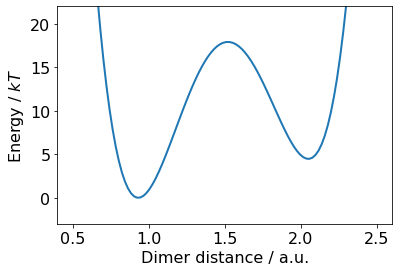

In [11]:
xx, xE = model_ld.plot_dimer_energy()
plt.ylim(-3, 22)
plt.xlabel('Dimer distance / a.u.')
plt.ylabel('Energy / $kT$')

Boltzmann Generator
-------

Construct Boltzmann generator

In [12]:
bg_ld = BoltzmannGenerator(
    'R' * 8,
    model_ld,
    nl_layers=3,
    nl_hidden=200
)

Layers of invertible NN: <RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [13]:
rc_loss_params = {
    'rc_function': model_ld.dimer_distance_tf, 
    'rc_min': 0.5, 
    'rc_max': 2.5
}

Functions to set "low energy" limit in both $x$ an $z$ space

In [14]:
def energy_cut_z(ndim, n_std=3):
    z = np.random.randn(10000, ndim)
    z_ener = 0.5 * np.sum(z**2, axis=1)
    std = np.sqrt(np.mean((z_ener - z_ener.mean())**2))
    # mean energies of samples from z + n_std times their standard deviation
    return z_ener.mean() + n_std*std

def low_energy_fraction(energies, E_max):
    low_energy_count = [np.count_nonzero(E<E_max) for E in energies]
    total_size = [E.shape[0] for E in energies]
    low_energy_fraction = np.array(low_energy_count) / total_size
    return low_energy_fraction

In [15]:
save_dir_and_prefix_ld = '../resources/bg_particle_dimer_ld/'
z_low_limit = energy_cut_z(model_ld.dim, n_std=3)
x_low_limit = 65

In [16]:
# RC entropy is calculated from histogram with 11 bins, see losses.py
max_rc_entropy = np.log(11) 

def plot_convergence(loss_vals, x_energies, z_energies, rc_loss_weight):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for loss_name in ["loss", "val_loss"]:
        axes[0].plot(loss_vals[loss_name], label=loss_name)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend(loc='upper right')
        
    line1, = axes[1].plot(low_energy_fraction(z_energies, E_max=z_low_limit)*100, label="$z$")
    line2, = axes[1].plot(low_energy_fraction(x_energies, E_max=x_low_limit)*100, label="$x$")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("% of samples with $E < E_{low}$")
    axes[1].set_ylim(-5, 105)
    
    rc_axis = axes[1].twinx()
    rc_loss = loss_vals.get('RC_loss', np.array([]))
    line3, = rc_axis.plot(-rc_loss/rc_loss_weight/max_rc_entropy, color='green', label="$H_{RC}$")
    rc_axis.yaxis.tick_right()
    rc_axis.set_ylim(-0.05,1.05)
    rc_axis.yaxis.set_label_position('right')
    rc_axis.set_ylabel("RC entropy / max possible")
    rc_axis.legend(loc='lower right', handles=[line1, line2, line3])

    plt.subplots_adjust(wspace=0.3)
    plt.show()

    
# Training script
def train_bg(bg, training_schedule, save_from_stage=3):
    for i, args in enumerate(training_schedule):
        input("Should training continue? (press Enter)")
        current_loss_vals, x_energies, z_energies = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            high_energy = args[6],
            print_total_loss_only = True,
            print_training_info_interval = 20,
            return_validation_energies = True,
            **rc_loss_params
        )
        if i + 1 >= save_from_stage:
            bg.save(save_dir_and_prefix + '/bg_model')
        
        plot_convergence(current_loss_vals, x_energies, z_energies, rc_loss_weight=args[2])

        

In [17]:
training_schedule = [
#    w_ML, w_KL, w_RC, iter, b_size,   lr, E_high  
    [   1,    0,    0,   20,    256, 1e-3,   1e4],
    [ 100,    1,    1,  200,   8000, 1e-4,   1e4],
    [ 100,    1,    5,  300,   8000, 1e-4,   1e4],
    [ 100,    1,   10,  300,   8000, 1e-4,   1e4],
    [  20,    1,   10, 1000,   8000, 1e-4,   2e3],
    [ 0.1,    1,   10, 2000,   8000, 1e-4,   1e3],
]

## Training

In [18]:
# Load BG if it's already trained.
# bg_ld.load(save_dir_and_prefix, load_latest_checkpoint=True)

In [19]:
training_dataset = training_dataset_ld
validation_dataset = validation_dataset_ld

Should training continue? (press Enter)
Iteration 0/20: loss: 338.63 val_loss: 68.64 


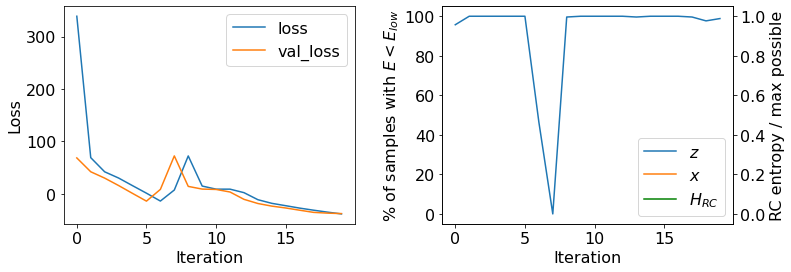

Should training continue? (press Enter)
Iteration 0/200: loss: 6277.47 val_loss: 5954.19 


../energy_models/particle_dimer.py:164: RuntimeWarning: overflow encountered in power
  E = 0.5 * self.params['eps'] * np.sum(D2rel**6, axis=(1, 2))


Iteration 20/200: loss: 620.62 val_loss: -269.63 
Iteration 40/200: loss: -4873.15 val_loss: -4965.85 
Iteration 60/200: loss: -5813.88 val_loss: -5857.53 
Iteration 80/200: loss: -6355.38 val_loss: -6356.08 
Iteration 100/200: loss: -6747.52 val_loss: -6741.92 
Iteration 120/200: loss: -7046.38 val_loss: -7019.95 
Iteration 140/200: loss: -7307.13 val_loss: -7316.06 
Iteration 160/200: loss: -7464.09 val_loss: -7490.26 
Iteration 180/200: loss: -7667.24 val_loss: -7681.74 


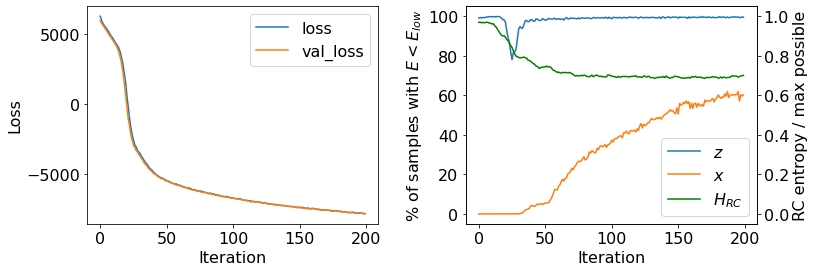

Should training continue? (press Enter)
Iteration 0/300: loss: -7860.53 val_loss: -7875.25 
Iteration 20/300: loss: -7979.58 val_loss: -8008.52 
Iteration 40/300: loss: -8131.32 val_loss: -8113.02 
Iteration 60/300: loss: -8180.29 val_loss: -8207.31 
Iteration 80/300: loss: -8305.51 val_loss: -8315.63 
Iteration 100/300: loss: -8409.42 val_loss: -8400.93 
Iteration 120/300: loss: -8486.39 val_loss: -8494.84 
Iteration 140/300: loss: -8545.73 val_loss: -8555.05 
Iteration 160/300: loss: -8608.09 val_loss: -8627.66 
Iteration 180/300: loss: -8682.77 val_loss: -8654.16 
Iteration 200/300: loss: -8703.53 val_loss: -8739.08 
Iteration 220/300: loss: -8781.59 val_loss: -8791.03 
Iteration 240/300: loss: -8817.38 val_loss: -8807.46 
Iteration 260/300: loss: -8878.50 val_loss: -8870.18 
Iteration 280/300: loss: -8931.61 val_loss: -8910.21 


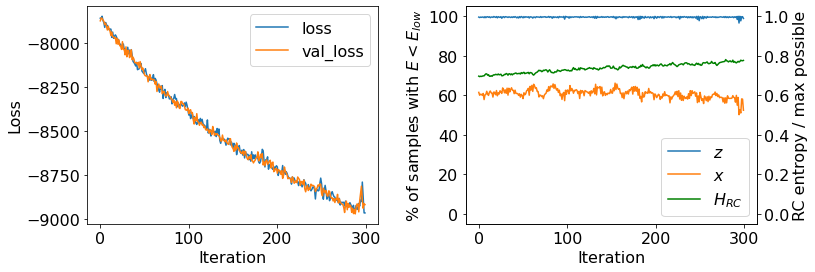

Should training continue? (press Enter)
Iteration 0/300: loss: -8930.47 val_loss: -8891.12 
Iteration 20/300: loss: -9003.49 val_loss: -8995.95 
Iteration 40/300: loss: -9027.13 val_loss: -8985.47 
Iteration 60/300: loss: -9052.06 val_loss: -9065.03 
Iteration 80/300: loss: -9107.66 val_loss: -9092.05 
Iteration 100/300: loss: -9152.12 val_loss: -9151.68 
Iteration 120/300: loss: -9184.43 val_loss: -9179.75 
Iteration 140/300: loss: -9153.41 val_loss: -9188.77 
Iteration 160/300: loss: -9233.07 val_loss: -9246.49 
Iteration 180/300: loss: -9230.43 val_loss: -9242.21 
Iteration 200/300: loss: -9283.47 val_loss: -9266.69 
Iteration 220/300: loss: -9309.34 val_loss: -9321.50 
Iteration 240/300: loss: -9285.75 val_loss: -9314.20 
Iteration 260/300: loss: -9371.37 val_loss: -9353.96 
Iteration 280/300: loss: -9349.72 val_loss: -9361.61 


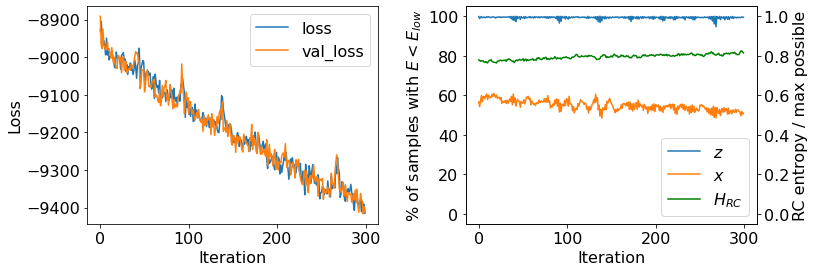

Should training continue? (press Enter)
Iteration 0/1000: loss: -1661.32 val_loss: -1659.12 
Iteration 20/1000: loss: -1676.40 val_loss: -1683.27 
Iteration 40/1000: loss: -1681.12 val_loss: -1678.61 
Iteration 60/1000: loss: -1684.88 val_loss: -1684.21 
Iteration 80/1000: loss: -1686.66 val_loss: -1690.01 
Iteration 100/1000: loss: -1686.91 val_loss: -1688.75 
Iteration 120/1000: loss: -1691.65 val_loss: -1687.68 
Iteration 140/1000: loss: -1688.44 val_loss: -1685.14 
Iteration 160/1000: loss: -1690.95 val_loss: -1690.20 
Iteration 180/1000: loss: -1695.41 val_loss: -1695.94 
Iteration 200/1000: loss: -1691.99 val_loss: -1695.62 
Iteration 220/1000: loss: -1694.96 val_loss: -1697.91 
Iteration 240/1000: loss: -1695.04 val_loss: -1699.70 
Iteration 260/1000: loss: -1698.41 val_loss: -1698.17 
Iteration 280/1000: loss: -1703.19 val_loss: -1697.69 
Iteration 300/1000: loss: -1703.47 val_loss: -1697.54 
Iteration 320/1000: loss: -1703.35 val_loss: -1701.98 
Iteration 340/1000: loss: -1702

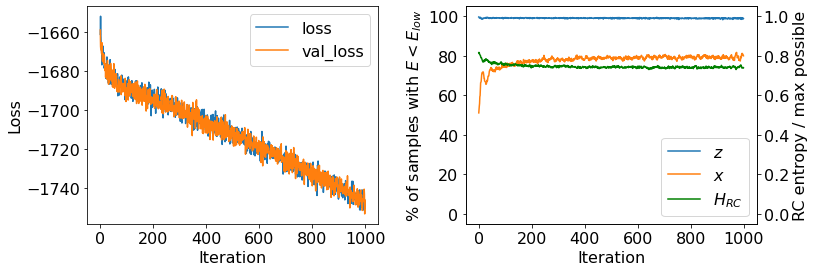

Should training continue? (press Enter)
Iteration 0/2000: loss: 229.97 val_loss: 232.83 
Iteration 20/2000: loss: 218.66 val_loss: 218.57 
Iteration 40/2000: loss: 217.33 val_loss: 216.85 
Iteration 60/2000: loss: 216.02 val_loss: 215.93 
Iteration 80/2000: loss: 215.33 val_loss: 215.29 
Iteration 100/2000: loss: 214.70 val_loss: 214.77 
Iteration 120/2000: loss: 214.75 val_loss: 214.99 
Iteration 140/2000: loss: 214.13 val_loss: 213.89 
Iteration 160/2000: loss: 214.13 val_loss: 214.27 
Iteration 180/2000: loss: 213.94 val_loss: 213.73 
Iteration 200/2000: loss: 213.63 val_loss: 213.53 
Iteration 220/2000: loss: 213.21 val_loss: 213.16 
Iteration 240/2000: loss: 212.78 val_loss: 212.72 
Iteration 260/2000: loss: 212.62 val_loss: 212.81 
Iteration 280/2000: loss: 212.51 val_loss: 212.56 
Iteration 300/2000: loss: 212.43 val_loss: 212.50 
Iteration 320/2000: loss: 212.67 val_loss: 212.25 
Iteration 340/2000: loss: 211.94 val_loss: 212.41 
Iteration 360/2000: loss: 211.93 val_loss: 211.9

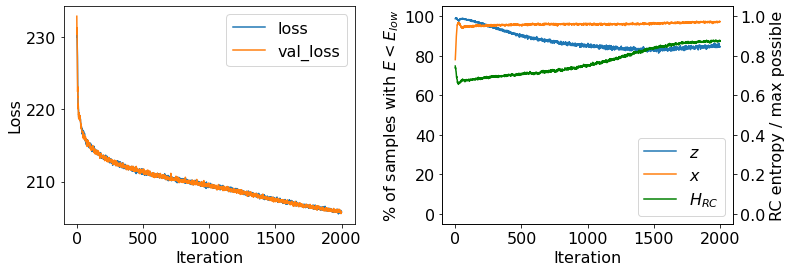

In [20]:
train_bg(bg_ld, training_schedule)

In [21]:
# Save the BG
# bg_ld.save(save_dir_and_prefix + '/bg_model')

## Evaluate BG

### Check sampling of configurations in $x$

In [22]:
_, sample_x, _, energies_x, _ = bg_ld.sample(n_sample=100000)

Check that random configuration looks normal.

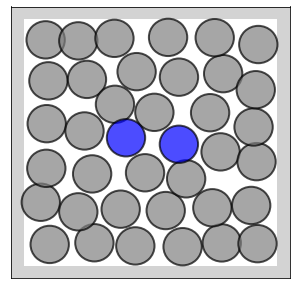

In [23]:
model_ld.draw_config(sample_x[np.random.randint(0, 10000)])

Text(0.5, 0, 'Dimer distance')

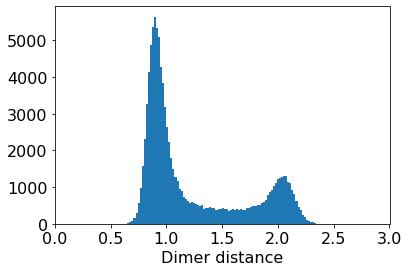

In [24]:
# Check sampling along RC
sample_d = model_ld.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=False)
plt.xlim(0, 3)
plt.xlabel("Dimer distance")

Text(0, 0.5, 'Probability')

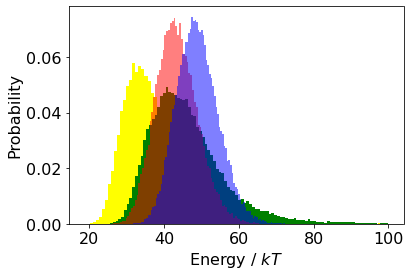

In [25]:
# Compare sampling of system energies by BG with the training dataset
# Closed states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True)
# Opened states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True)
# Closed states in training dataset
plt.hist(model_ld.energy(traj_closed_train_ld), 100, color='red', alpha=0.5, density=True)
# Opened states in training dataset
plt.hist(model_ld.energy(traj_open_train_ld), 100, color='blue', alpha=0.5, density=True)
plt.xlabel("Energy / $kT$")
plt.ylabel("Probability")

Text(0.5, 0, 'Energy / $kT$')

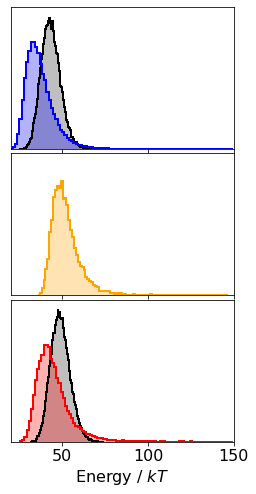

In [26]:
traj_closed_train_energies_ld = model_ld.energy(traj_closed_train_ld)
traj_open_train_energies_ld = model_ld.energy(traj_open_train_ld)

I_closed = np.where(model_ld.dimer_distance(sample_x) < 1.3)[0]
energies_x_closed = energies_x[I_closed][energies_x[I_closed]<150]
I_ts = np.where(np.logical_and(model_ld.dimer_distance(sample_x) > 1.3, model_ld.dimer_distance(sample_x) < 1.7))[0]
energies_x_ts = energies_x[I_ts][energies_x[I_ts]<150]
I_open = np.where(model_ld.dimer_distance(sample_x) > 1.7)[0]
energies_x_open = energies_x[I_open][energies_x[I_open]<150]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 8), sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

axes[0].hist(traj_closed_train_energies_ld, 100, color='black', histtype='step', linewidth=2, density=True);
axes[0].hist(traj_closed_train_energies_ld, 100, color='grey', alpha=0.5, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', histtype='step', linewidth=2, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', alpha=0.3, density=True);
axes[0].set_yticks([])
axes[0].set_ylim(0, 0.08)
axes[0].set_xlim(20, 150)

axes[1].hist(energies_x_ts, 100, color='orange', histtype='step', linewidth=2, density=True);
axes[1].hist(energies_x_ts, 100, color='orange', alpha=0.3, density=True);
axes[1].set_yticks([])
axes[1].set_ylim(0, 0.08)
axes[1].set_xlim(20, 150)

axes[2].hist(traj_open_train_energies_ld, 100, color='black', histtype='step', linewidth=2, density=True);
axes[2].hist(traj_open_train_energies_ld, 100, color='grey', alpha=0.5, density=True);
axes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);
axes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);
axes[2].set_yticks([])
axes[2].set_xlim(20, 150)
axes[2].set_ylim(0, 0.08)
axes[2].set_xlabel('Energy / $kT$')

### Latent interpolation

In [27]:
def latent_interpolation(bg, x1, x2, n_step=1000, through_origin=False):
    lambdas = np.array([np.linspace(0, 1, num=n_step)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    if through_origin:
        z_path_1 = z1 * (1-lambdas[::2])
        z_path_2 = z2 * (lambdas[::2]) 
        z_path = np.vstack([zpath1, zpath2])
    else:
        z_path = z1 + lambdas*(z2 - z1)
    x_path = bg.transform_zx(z_path)
    return x_path

In [28]:
# Try to find minimum energy path
E_min = 1e9
best_path = None
N = 90

i_min = None
j_min = None
for i in range(N):
    if i % 10 == 0:
        print("i =", i)
    for j in range(N):
        path = latent_interpolation(bg_ld, traj_closed_train_ld[i*100], traj_open_train_ld[j*100], n_step=9)
        E = model_ld.energy(path).max()
        if E < E_min:
            E_min = E
            best_path = path
            i_min = i
            j_min = j
            
print("E_min:", E_min)

i = 0
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
E_min: 78.50691986083984


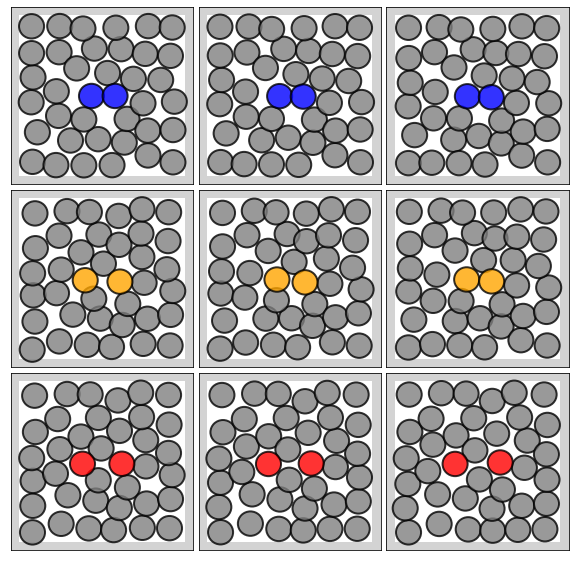

In [31]:
# Show the best path
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
model_ld.draw_config(best_path[0], axis=axes[0, 0], dimer_color='blue', alpha=0.8)
model_ld.draw_config(best_path[1], axis=axes[0, 1], dimer_color='blue', alpha=0.8)
model_ld.draw_config(best_path[2], axis=axes[0, 2], dimer_color='blue', alpha=0.8)

model_ld.draw_config(best_path[3], axis=axes[1, 2], dimer_color='orange', alpha=0.8)
model_ld.draw_config(best_path[4], axis=axes[1, 1], dimer_color='orange', alpha=0.8)
model_ld.draw_config(best_path[5], axis=axes[1, 0], dimer_color='orange', alpha=0.8)

model_ld.draw_config(best_path[6], axis=axes[2, 0], dimer_color='red', alpha=0.8)
model_ld.draw_config(best_path[7], axis=axes[2, 1], dimer_color='red', alpha=0.8)
model_ld.draw_config(best_path[8], axis=axes[2, 2], dimer_color='red', alpha=0.8)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

### Free energy

Load refeence data from umbrella sampling.

In [32]:
us_data = np.load('../resources/bistable_dimer_changed_density_umbrella_sampling_data.npz', allow_pickle=True)

In [34]:
us_positions_ld = us_data['umbrella_positions_ld_mbar']
us_free_energy_ld = us_data['umbrella_FE_ld_mbar']
us_free_energy_ld -= us_free_energy_ld.min()

In [35]:
_, sample_x, _, _, sample_logw = bg_ld.sample(200000)
dimer_distances = model_ld.dimer_distance(sample_x)

In [36]:
bin_values, Fs = free_energy_bootstrap(dimer_distances, 100, (0.4, 2.6), log_weights=sample_logw, n_bootstrap=2000)
F_calc = mean_finite(Fs, axis=0)
F_calc_error = std_finite(Fs, axis=0)

../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


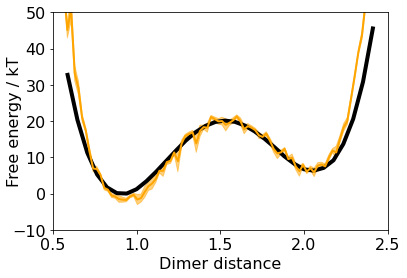

In [38]:
axis = plt.gca()
F_calc_shifted = F_calc - F_calc.min()

axis.plot(us_positions_ld, us_free_energy_ld, color='black', linewidth=4)
axis.plot(bin_values, F_calc, color='orange', linewidth=2)
axis.fill_between(bin_values, F_calc-F_calc_error, F_calc+F_calc_error, color='orange', alpha=0.5)
# axis.errorbar(bin_values, F_calc_shifted, F_calc_error, color='orange', linewidth=2)
axis.set_xlim(0.5, 2.5)
axis.set_ylim(-10, 50)
axis.set_xlabel('Dimer distance')
axis.set_ylabel('Free energy / kT', labelpad=-10)
plt.savefig(results_dir + "free_energy_profile_ld.png")

# 5% higher density

In [39]:
# Loading a dictionary from np.ndarray is a little bit complicated
params_hd = dict(enumerate(trajdict['hd_params'].flatten()))[0]
traj_closed_train_hd = trajdict['hd_traj_closed_train_hungarian']
traj_open_train_hd = trajdict['hd_traj_open_train_hungarian']
traj_closed_test_hd = trajdict['hd_traj_closed_test_hungarian']
traj_open_test_hd = trajdict['hd_traj_open_test_hungarian']

Construct training and validation datasets by merging trajectories from opened and closed dimer states.

In [40]:
training_dataset_hd = np.vstack([traj_closed_train_hd, traj_open_train_hd])
validation_dataset_hd = np.vstack([traj_closed_test_hd, traj_open_test_hd])

In [41]:
print("Size of training dataset:", training_dataset_hd.shape[0])
print("Size of validation dataset:", validation_dataset_hd.shape[0])

Size of training dataset: 99800
Size of validation dataset: 99800


## Energy model

In [42]:
print(params_hd)
model_hd = ParticleDimer(params=params_hd)

{'n_solvent': 36, 'eps': 1.0, 'rm': 1.1, 'dimer_slope': 2, 'dimer_a': 25.0, 'dimer_b': 10.0, 'dimer_dmid': 1.5, 'dimer_k': 20.0, 'box_halfsize': 2.925, 'box_k': 100.0, 'grid_k': 0.0}


## Boltzmann Generator
Construct Boltzmann generator

In [43]:
bg_hd = BoltzmannGenerator(
    'R' * 8,
    model_hd,
    nl_layers=3,
    nl_hidden=200
)

Layers of invertible NN: <RRRRRRRR>
< 76 0 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
R 38 38 0
> 38 38 0


In [44]:
rc_loss_params = {
    'rc_function': model_hd.dimer_distance_tf, 
    'rc_min': 0.5, 
    'rc_max': 2.5
}

Functions to set "low energy" limit in both $x$ an $z$ space

In [45]:
save_dir_and_prefix_hd = '../resources/bg_particle_dimer_hd'
z_low_limit = energy_cut_z(model_ld.dim, n_std=3)
x_low_limit = 90

In [46]:
training_schedule = [
#    w_ML, w_KL, w_RC, iter, b_size,   lr, E_high  
    [   1,    0,    0,   20,    256, 1e-3,   1e4],
    [ 100,    1,    1,  200,   8000, 1e-4,   1e4],
    [ 100,    1,    5,  300,   8000, 1e-4,   1e4],
    [ 100,    1,   10,  300,   8000, 1e-4,   1e4],
    [  20,    1,   10, 1000,   8000, 1e-4,   2e3],
    [ 0.1,    1,   12, 3000,   8000, 1e-4,   1e3],
]

## Training

In [47]:
# Load BG if it's already trained.
# bg_hd.load(save_dir_and_prefix_hd, load_latest_checkpoint=True)

In [48]:
training_dataset = training_dataset_hd
validation_dataset = validation_dataset_hd
save_dir_and_prefix = save_dir_and_prefix_hd

Should training continue? (press Enter)
Iteration 0/20: loss: 241.44 val_loss: 53.34 


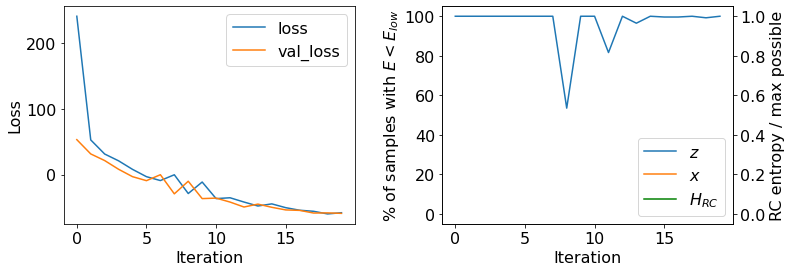

Should training continue? (press Enter)
Iteration 0/200: loss: 4190.45 val_loss: 3740.75 
Iteration 20/200: loss: -4074.38 val_loss: -4269.08 
Iteration 40/200: loss: -6367.10 val_loss: -6439.70 
Iteration 60/200: loss: -7206.18 val_loss: -7235.68 
Iteration 80/200: loss: -7735.71 val_loss: -7754.76 
Iteration 100/200: loss: -8161.08 val_loss: -8125.61 
Iteration 120/200: loss: -8472.51 val_loss: -8484.79 
Iteration 140/200: loss: -8747.30 val_loss: -8737.57 
Iteration 160/200: loss: -9003.43 val_loss: -9013.63 
Iteration 180/200: loss: -9177.69 val_loss: -9173.28 


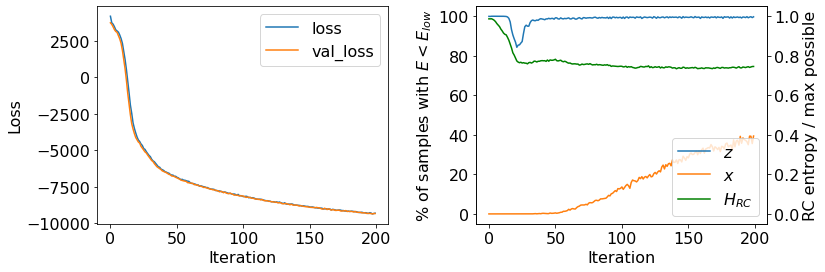

Should training continue? (press Enter)
Iteration 0/300: loss: -9379.69 val_loss: -9368.68 
Iteration 20/300: loss: -9502.47 val_loss: -9490.76 
Iteration 40/300: loss: -9610.67 val_loss: -9609.52 
Iteration 60/300: loss: -9744.23 val_loss: -9753.37 
Iteration 80/300: loss: -9810.86 val_loss: -9847.72 
Iteration 100/300: loss: -9926.15 val_loss: -9910.51 
Iteration 120/300: loss: -10046.99 val_loss: -10023.20 
Iteration 140/300: loss: -10049.83 val_loss: -10080.26 
Iteration 160/300: loss: -10154.23 val_loss: -10150.50 
Iteration 180/300: loss: -10218.92 val_loss: -10244.75 
Iteration 200/300: loss: -10264.70 val_loss: -10257.02 
Iteration 220/300: loss: -10342.29 val_loss: -10328.54 
Iteration 240/300: loss: -10369.30 val_loss: -10433.02 
Iteration 260/300: loss: -10356.64 val_loss: -10367.63 
Iteration 280/300: loss: -10426.55 val_loss: -10461.80 


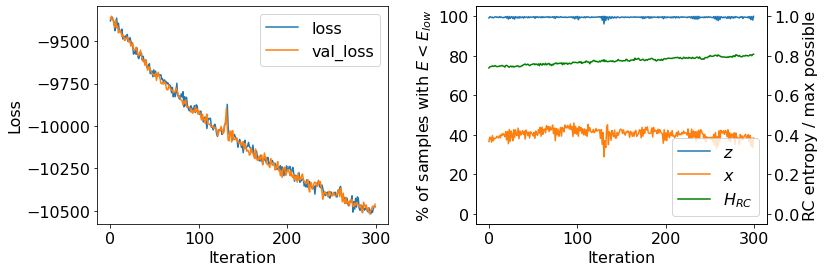

Should training continue? (press Enter)
Iteration 0/300: loss: -10519.17 val_loss: -10505.36 
Iteration 20/300: loss: -10543.49 val_loss: -10602.99 
Iteration 40/300: loss: -10574.88 val_loss: -10576.52 
Iteration 60/300: loss: -10631.27 val_loss: -10640.60 
Iteration 80/300: loss: -10709.31 val_loss: -10691.00 
Iteration 100/300: loss: -10737.57 val_loss: -10728.56 
Iteration 120/300: loss: -10759.82 val_loss: -10720.85 
Iteration 140/300: loss: -10779.39 val_loss: -10785.70 
Iteration 160/300: loss: -10795.79 val_loss: -10800.50 
Iteration 180/300: loss: -10874.51 val_loss: -10864.36 
Iteration 200/300: loss: -10880.93 val_loss: -10885.11 
Iteration 220/300: loss: -10874.75 val_loss: -10922.69 
Iteration 240/300: loss: -10909.01 val_loss: -10915.45 
Iteration 260/300: loss: -10930.95 val_loss: -10911.83 
Iteration 280/300: loss: -10984.35 val_loss: -10937.08 


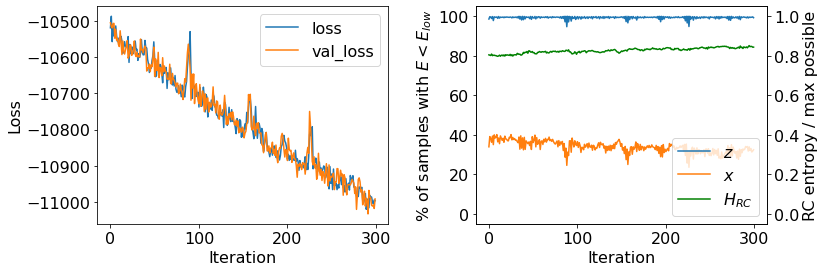

Should training continue? (press Enter)
Iteration 0/1000: loss: -1937.98 val_loss: -1944.32 
Iteration 20/1000: loss: -1958.80 val_loss: -1963.20 
Iteration 40/1000: loss: -1967.02 val_loss: -1967.24 
Iteration 60/1000: loss: -1970.65 val_loss: -1968.61 
Iteration 80/1000: loss: -1961.61 val_loss: -1973.94 
Iteration 100/1000: loss: -1974.50 val_loss: -1975.60 
Iteration 120/1000: loss: -1973.20 val_loss: -1975.03 
Iteration 140/1000: loss: -1979.44 val_loss: -1984.01 
Iteration 160/1000: loss: -1979.42 val_loss: -1977.59 
Iteration 180/1000: loss: -1979.87 val_loss: -1981.01 
Iteration 200/1000: loss: -1975.74 val_loss: -1982.80 
Iteration 220/1000: loss: -1982.81 val_loss: -1986.28 
Iteration 240/1000: loss: -1985.82 val_loss: -1985.12 
Iteration 260/1000: loss: -1983.96 val_loss: -1984.22 
Iteration 280/1000: loss: -1983.36 val_loss: -1984.83 
Iteration 300/1000: loss: -1989.10 val_loss: -1985.43 
Iteration 320/1000: loss: -1982.94 val_loss: -1992.94 
Iteration 340/1000: loss: -1992

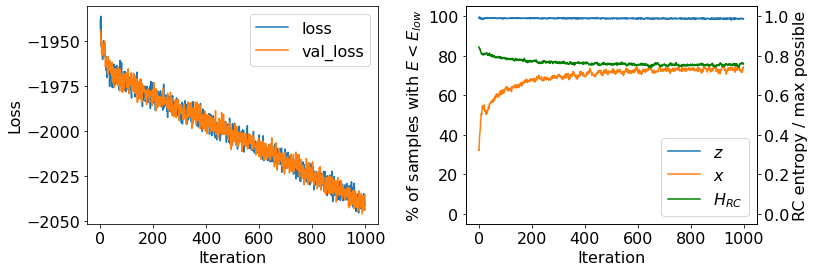

Should training continue? (press Enter)
Iteration 0/3000: loss: 266.77 val_loss: 263.87 
Iteration 20/3000: loss: 252.81 val_loss: 252.01 
Iteration 40/3000: loss: 250.79 val_loss: 250.37 
Iteration 60/3000: loss: 249.80 val_loss: 250.42 
Iteration 80/3000: loss: 249.37 val_loss: 249.10 
Iteration 100/3000: loss: 248.44 val_loss: 248.50 
Iteration 120/3000: loss: 248.25 val_loss: 248.44 
Iteration 140/3000: loss: 247.95 val_loss: 247.89 
Iteration 160/3000: loss: 247.34 val_loss: 247.48 
Iteration 180/3000: loss: 247.26 val_loss: 247.30 
Iteration 200/3000: loss: 247.06 val_loss: 247.12 
Iteration 220/3000: loss: 246.57 val_loss: 246.52 
Iteration 240/3000: loss: 246.45 val_loss: 246.69 
Iteration 260/3000: loss: 246.40 val_loss: 246.43 
Iteration 280/3000: loss: 246.29 val_loss: 246.06 
Iteration 300/3000: loss: 246.06 val_loss: 245.98 
Iteration 320/3000: loss: 245.56 val_loss: 245.64 
Iteration 340/3000: loss: 245.76 val_loss: 245.82 
Iteration 360/3000: loss: 245.58 val_loss: 245.5

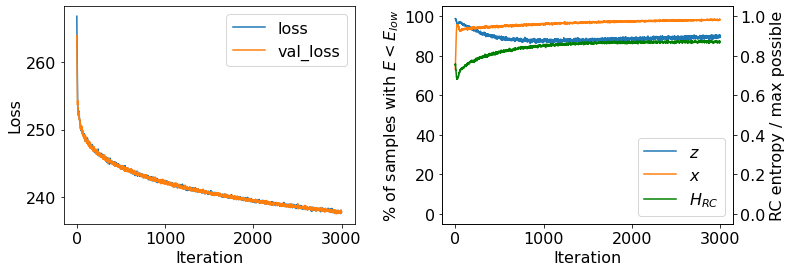

In [49]:
train_bg(bg_hd, training_schedule, save_from_stage=10)

In [50]:
# Save the BG
# bg_hd.save(save_dir_and_prefix_hd + '/bg_model')

## Evaluate BG

### Check sampling of configurations in $x$

In [51]:
_, sample_x, _, energies_x, _ = bg_hd.sample(n_sample=100000)

Check that random configuration looks normal.

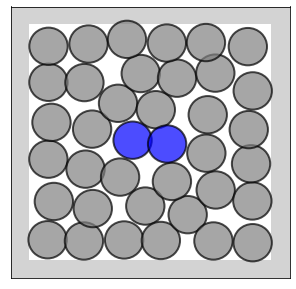

In [52]:
model_hd.draw_config(sample_x[np.random.randint(0, 10000)])

Text(0.5, 0, 'Dimer distance')

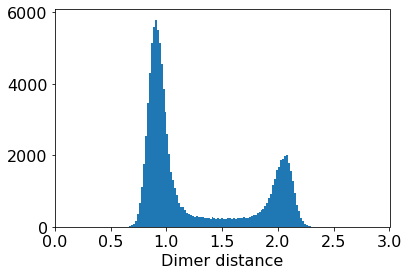

In [53]:
# Check sampling along RC
sample_d = model_hd.dimer_distance(sample_x)
plt.hist(sample_d[sample_d < 3], 100, log=False)
plt.xlim(0, 3)
plt.xlabel("Dimer distance")

Text(0, 0.5, 'Probability')

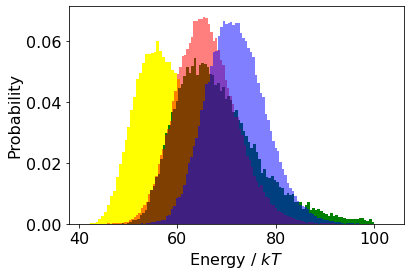

In [54]:
# Compare sampling of system energies by BG with the training dataset
# Closed states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d<1.5)], 100, color='yellow', density=True)
# Opened states by BG
plt.hist(energies_x[np.bitwise_and(energies_x<100, sample_d>1.5)], 100, color='green', density=True)
# Closed states in training dataset
plt.hist(model_hd.energy(traj_closed_train_hd), 100, color='red', alpha=0.5, density=True)
# Opened states in training dataset
plt.hist(model_hd.energy(traj_open_train_hd), 100, color='blue', alpha=0.5, density=True)
plt.xlabel("Energy / $kT$")
plt.ylabel("Probability")

Text(0.5, 0, 'Energy / $kT$')

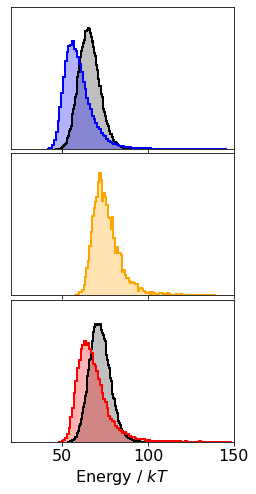

In [55]:
traj_closed_train_energies = model_hd.energy(traj_closed_train_hd)
traj_open_train_energies = model_hd.energy(traj_open_train_hd)

I_closed = np.where(model_ld.dimer_distance(sample_x) < 1.3)[0]
energies_x_closed = energies_x[I_closed][energies_x[I_closed]<150]
I_ts = np.where(np.logical_and(model_hd.dimer_distance(sample_x) > 1.3, 
                               model_hd.dimer_distance(sample_x) < 1.7))[0]
energies_x_ts = energies_x[I_ts][energies_x[I_ts]<150]
I_open = np.where(model_ld.dimer_distance(sample_x) > 1.7)[0]
energies_x_open = energies_x[I_open][energies_x[I_open]<150]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(4, 8), sharex=True)
plt.subplots_adjust(wspace=0.03, hspace=0.03)

axes[0].hist(traj_closed_train_energies, 100, color='black', histtype='step', linewidth=2, density=True);
axes[0].hist(traj_closed_train_energies, 100, color='grey', alpha=0.5, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', histtype='step', linewidth=2, density=True);
axes[0].hist(energies_x_closed, 100, color='blue', alpha=0.3, density=True);
axes[0].set_yticks([])
axes[0].set_ylim(0, 0.08)
axes[0].set_xlim(20, 150)

axes[1].hist(energies_x_ts, 100, color='orange', histtype='step', linewidth=2, density=True);
axes[1].hist(energies_x_ts, 100, color='orange', alpha=0.3, density=True);
axes[1].set_yticks([])
axes[1].set_ylim(0, 0.08)
axes[1].set_xlim(20, 150)

axes[2].hist(traj_open_train_energies, 100, color='black', histtype='step', linewidth=2, density=True);
axes[2].hist(traj_open_train_energies, 100, color='grey', alpha=0.5, density=True);
axes[2].hist(energies_x_open, 100, color='red', histtype='step', linewidth=2, density=True);
axes[2].hist(energies_x_open, 100, color='red', alpha=0.3, density=True);
axes[2].set_yticks([])
axes[2].set_xlim(20, 150)
axes[2].set_ylim(0, 0.08)
axes[2].set_xlabel('Energy / $kT$')

### Latent interpolation

In [59]:
# Try to find minimum energy path
E_min = 1e9
best_path = None
N = 100

i_min = None
j_min = None
for i in range(N):
    if i % 10 == 0:
        print("i =", i)
    for j in range(N):
        path = latent_interpolation(bg_hd, traj_closed_train_hd[i*100], traj_open_train_hd[j*100], n_step=9)
        E = model_hd.energy(path).max()
        if E < E_min:
            E_min = E
            best_path = path
            i_min = i
            j_min = j
            
print("E_min:", E_min)

i = 0
i = 10
i = 20
i = 30
i = 40
i = 50
i = 60
i = 70
i = 80
i = 90
E_min: 89.55166625976562


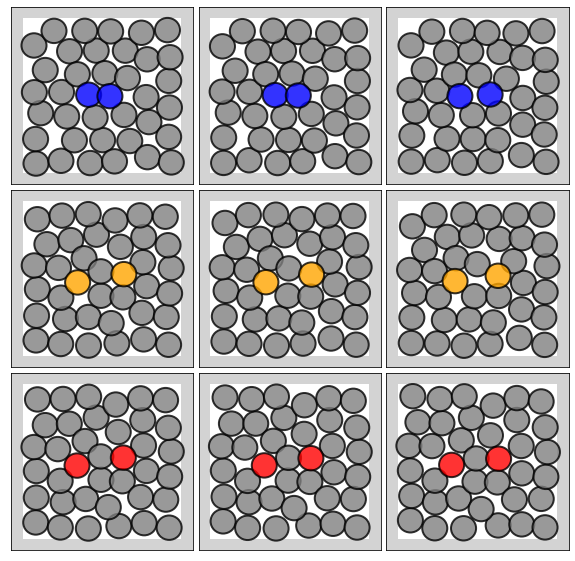

In [61]:
# Show the best path
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
model_hd.draw_config(best_path[0], axis=axes[0, 0], dimer_color='blue', alpha=0.8)
model_hd.draw_config(best_path[1], axis=axes[0, 1], dimer_color='blue', alpha=0.8)
model_hd.draw_config(best_path[2], axis=axes[0, 2], dimer_color='blue', alpha=0.8)

model_hd.draw_config(best_path[3], axis=axes[1, 2], dimer_color='orange', alpha=0.8)
model_hd.draw_config(best_path[4], axis=axes[1, 1], dimer_color='orange', alpha=0.8)
model_hd.draw_config(best_path[5], axis=axes[1, 0], dimer_color='orange', alpha=0.8)

model_hd.draw_config(best_path[6], axis=axes[2, 0], dimer_color='red', alpha=0.8)
model_hd.draw_config(best_path[7], axis=axes[2, 1], dimer_color='red', alpha=0.8)
model_hd.draw_config(best_path[8], axis=axes[2, 2], dimer_color='red', alpha=0.8)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
plt.savefig(results_dir + 'latent_interpolation_hd.pdf')

In [62]:
%%capture
# Create animation of transition
path = latent_interpolation(bg_hd, traj_closed_train_hd[i_min*100], traj_open_train_hd[j_min*100], n_step=150)
fig, axis = plt.subplots(1, 1, figsize=(10, 10))
for i, x in enumerate(path):
    dim_distance = model_hd.dimer_distance(np.expand_dims(x, axis=0))[0]
    if dim_distance < 1.3:
        dimer_color = 'blue'
    elif dim_distance > 1.7:
        dimer_color = 'red'
    else:
        dimer_color = 'orange'
    model_hd.draw_config(x, axis=axis, dimer_color=dimer_color, alpha=0.8)
    fig.savefig(f'../results/bistable_dimer_changed_density/transition_animation_hd/frame_{i:03}.png', 
                format='png')
    if i != 149:
        flush = plt.cla()

### Free energy
Load refeence data from umbrella sampling.

In [66]:
us_positions = us_data['umbrella_positions_hd_mbar']
us_free_energy = us_data['umbrella_FE_hd_mbar']
us_free_energy = us_free_energy - us_free_energy.min()

Calculate free energy profile along dimer distance using BG.

In [67]:
_, sample_x, _, _, sample_logw = bg_hd.sample(200000)
dimer_distances = model_hd.dimer_distance(sample_x)

In [68]:
bin_values, Fs = free_energy_bootstrap(dimer_distances, 100, (0.4, 2.6), log_weights=sample_logw, n_bootstrap=2000)
F_calc = mean_finite(Fs, axis=0)
F_calc_error = std_finite(Fs, axis=0)

../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


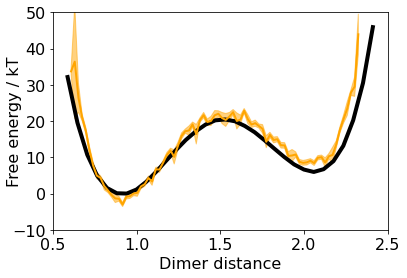

In [69]:
axis = plt.gca()
F_calc_shifted = F_calc - F_calc.min()

axis.plot(us_positions, us_free_energy, color='black', linewidth=4)
axis.plot(bin_values, F_calc, color='orange', linewidth=2)
axis.fill_between(bin_values, F_calc-F_calc_error, F_calc+F_calc_error, color='orange', alpha=0.5)
# axis.errorbar(bin_values, F_calc_shifted, F_calc_error, color='orange', linewidth=2)
axis.set_xlim(0.5, 2.5)
axis.set_ylim(-10, 50)
axis.set_xlabel('Dimer distance')
axis.set_ylabel('Free energy / kT', labelpad=-10)
plt.savefig(results_dir + "free_energy_profile_hd.png")